# MultiAgentEnvironment: simple Map

In [1]:
#%autosave 30
import glob
import sys
from operator import itemgetter
import numpy as np
import random
import time
import math

import networkx as nx
from networkx.algorithms.shortest_paths.generic import shortest_path_length

import ray
from ray import tune
#from ray.tune.logger import pretty_print
from ray.rllib.policy.policy import Policy, PolicySpec
from ray.rllib.models.tf.tf_modelv2 import TFModelV2
from ray.rllib.models.tf.fcnet import FullyConnectedNetwork

#from ray.rllib.agents.callbacks import DefaultCallbacks
from ray.rllib.env import MultiAgentEnv
from ray.rllib.utils.framework import try_import_tf

from gym.spaces import Discrete, Box, Tuple, MultiDiscrete, Dict, MultiBinary
from ray.rllib.utils.spaces.repeated import Repeated

import matplotlib.pyplot as plt

tf1, tf, tfv = try_import_tf()  # prefered TF import for Ray.io

from threading import Thread, Event

print("Imports successful")

Imports successful


In [2]:
######## Utility Classes ########
class BoolTimer(Thread):
    """A boolean value that toggles after a specified number of seconds:
    
    Example:
        bt = BoolTimer(30.0, False)
        bt.start()

    Used in the Centrality Baseline to limit the computation time.
    """

    def __init__(self, interval, initial_state=True):
        Thread.__init__(self)
        self.interval = interval
        self.state = initial_state
        self.finished = Event()

    def __bool__(self):
        return bool(self.state)

    def run(self):
        self.finished.wait(self.interval)
        if not self.finished.is_set():
            self.state = not self.state
        self.finished.set()


######## Static helper functions ########
def shuffle_actions(action_dict, check_space = False):
    """
        Used to shuffle the action dict to ensure that agents with a lower id are not always preferred
        when picking up parcels over other agents that chose the same action.
        For debugging: Can also be used to check if all actions are in the action_space.
    """
    keys = list(action_dict)
    random.shuffle(keys)
    shuffled = {}

    for agent in keys:
        if check_space:  #assert actions are in action space -> disable for later trainig, extra check while development
            assert self.action_space.contains(action_dict[agent]),f"Action {action_dict[agent]} taken by agent {agent} not in action space"
        shuffled[agent] = action_dict[agent]

    return shuffled



def load_graph(data):
    """Loads topology (map) from json file into a networkX Graph and returns the graph"""

    nodes = data["nodes"]
    edges = data["edges"]

    g = nx.DiGraph()  # directed graph
    g.add_nodes_from(nodes)
    g.edges(data=True)

   
    for node in nodes:  # add attribute values
        g.nodes[node]["id"] = nodes[node]["id"]
        g.nodes[node]["type"] = nodes[node]["type"]

    for edge in edges:  # add edges with attributes
        f = edges[edge]["from"]
        t = edges[edge]["to"]
        
        weight_road, weight_air, _type = sys.maxsize, sys.maxsize, None
        
        if edges[edge]["road"] >= 0:
            weight_road = edges[edge]["road"]
            _type = 'road'
        if edges[edge]["air"] >= 0:
            weight_air = edges[edge]["air"]
            _type = 'both' if _type == 'road' else 'air'

        weight = min(weight_road, weight_air)  # needed for optimality baseline
        
        g.add_edge(f, t, type=_type, road= weight_road, air=weight_air, weight=weight)

    return g

## Environment Code

In [3]:
# Map definition
topology = {
    'nodes': {
            0: {'id': 1, 'type': 'parking'},
            1: {'id': 1, 'type': 'parking'},
            2: {'id': 2, 'type': 'parking'},
            3: {'id': 3, 'type': 'parking'},
            4: {'id': 4, 'type': 'parking'},
            5: {'id': 5, 'type': 'air'},
            6: {'id': 6, 'type': 'parking'},
            7: {'id': 7, 'type': 'air'},
            8: {'id': 8, 'type': 'parking'},
            9: {'id': 9, 'type': 'parking'},
            10: {'id': 10, 'type': 'parking'},
            11: {'id': 11, 'type': 'air'}
    },
    'edges': {
    ## Outer Ring    --> Road much (!) faster than drones
    "e01":{"from": 0,"to": 1,"road": 10, "air": 40},
    "e02":{"from": 1,"to": 0,"road": 10, "air": 40},
    "e03":{"from": 1,"to": 4,"road": 8, "air": 6},        
    "e04":{"from": 4,"to": 1,"road": 8, "air": 6},
    "e03":{"from": 4,"to": 2,"road": 8, "air": 6},        
    "e04":{"from": 2,"to": 4,"road": 8, "air": 6},
    "e05":{"from": 2,"to": 3,"road": 10, "air": 30},
    "e06":{"from": 3,"to": 2,"road": 10, "air": 30},
    "e07":{"from": 3,"to": 0,"road": 10, "air": 40},
    "e08":{"from": 0,"to": 3,"road": 8, "air": 35}, 
    ## Inner Nodes  --> Reinfahren langsamer als rausfahren
    ##              --> 
    "e11":{"from": 4,"to": 6,"road": 2, "air": 5},        
    "e12":{"from": 6,"to": 4,"road": 2, "air": 5},
    "e13":{"from": 0,"to": 6,"road": 6, "air": -1},
    "e14":{"from": 6,"to": 0,"road": 6, "air": -1},
    "e15":{"from": 3,"to": 6,"road": 6, "air": -1},
    "e16":{"from": 6,"to": 3,"road": 6, "air": -1},   
    ## Outliers   --> Distance about equal if both exist!
    "e17":{"from": 4,"to": 5,"road": 2, "air": 2},        
    "e18":{"from": 5,"to": 4,"road": 2, "air": 2},
    "e19":{"from": 6,"to": 7,"road": -1, "air": 2},
    "e20":{"from": 7,"to": 6,"road": -1, "air": 2},
    "e21":{"from": 3,"to": 11,"road": -1, "air": 3},
    "e22":{"from": 11,"to": 3,"road": -1, "air": 3},     
    ## Upper left square  --> Hier besser mit den Drohnen agieren, Falls Sie da sind!!
    "e23":{"from": 0,"to": 8,"road": -1, "air": 4},        
    "e24":{"from": 8,"to": 0,"road": -1, "air": 4},
    "e25":{"from": 8,"to": 9,"road": 3, "air": 3},
    "e26":{"from": 9,"to": 8,"road": 3, "air": 3},
    "e27":{"from": 9,"to": 10,"road": 3, "air": 3},
    "e28":{"from": 10,"to": 9,"road": 3, "air": 3},
    "e29":{"from": 0,"to": 10,"road": 3, "air": 3},
    "e30":{"from": 10,"to": 0,"road": 3, "air": 3}  
    }
}

In [4]:
class Map_Environment(MultiAgentEnv):
    
    def __init__(self, env_config: dict = {}):
        # ensure config file includes all necessary settings
        assert 'NUMBER_STEPS_PER_EPISODE' in env_config
        assert 'NUMBER_OF_DRONES' in env_config
        assert 'NUMBER_OF_CARS' in env_config
        assert 'INIT_NUMBER_OF_PARCELS' in env_config
        assert 'TOPOLOGY' in env_config
        assert 'MAX_NUMBER_OF_PARCELS' in env_config
        assert 'THRESHOLD_ADD_NEW_PARCEL' in env_config
        assert 'BASELINE_FLAG' in env_config
        assert 'BASELINE_TIME_CONSTRAINT' in env_config
        assert 'BASELINE_OPT_CONSTANT' in env_config
        assert 'CHARGING_STATION_NODES' in env_config
        assert 'REWARDS' in env_config
        
        self.graph = load_graph(topology)
        

        # Map config
        self.NUMBER_OF_DRONES = env_config['NUMBER_OF_DRONES']
        self.NUMBER_OF_CARS = env_config['NUMBER_OF_CARS']
        self.NUMBER_OF_EDGES = self.graph.number_of_edges()
        self.NUMBER_OF_NODES = self.graph.number_of_nodes()
        self.CHARGING_STATION_NODES = env_config['CHARGING_STATION_NODES']           
        self.MAX_BATTERY_POWER = env_config['MAX_BATTERY_POWER']
       

        # Simulation config
        self.NUMBER_STEPS_PER_EPISODE = env_config['NUMBER_STEPS_PER_EPISODE']
        self.INIT_NUMBER_OF_PARCELS = env_config['INIT_NUMBER_OF_PARCELS']
        self.RANDOM_SEED = env_config.get('RANDOM_SEED', None)
        self.MAX_NUMBER_OF_PARCELS = env_config['MAX_NUMBER_OF_PARCELS']
        self.THRESHOLD_ADD_NEW_PARCEL = env_config['THRESHOLD_ADD_NEW_PARCEL']
        self.BASELINE_FLAG = env_config['BASELINE_FLAG']
        self.BASELINE_TIME_CONSTRAINT = env_config['BASELINE_TIME_CONSTRAINT']
        self.BASELINE_OPT_CONSTANT = env_config['BASELINE_OPT_CONSTANT']
 
        self.DEBUG_LOG = env_config.get('DEBUG_LOGS', False)
        # Some Sanity Checks on the settings
        if self.DEBUG_LOG: assert self.MAX_NUMBER_OF_PARCELS >= self.INIT_NUMBER_OF_PARCELS, "Number of initial parcels exceeds max parcel limit"

        #Reward constants
        self.STEP_PENALTY = env_config['REWARDS']['STEP_PENALTY']
        self.PARCEL_DELIVERED = env_config['REWARDS']['PARCEL_DELIVERED']
        # compute other rewards
        self.BATTERY_DIED = self.STEP_PENALTY * self.NUMBER_STEPS_PER_EPISODE
        self.BATTERY_DIED_WITH_PARCEL = self.BATTERY_DIED * 2
        #self.DELIVERY_CONTRIBUTION: depends on active agents --> computed when given in prepare_global_reward()
        #self.ALL_DELIVERED_CONTRIB: depends on active agents --> computed when given in prepare_global_reward(episode_success=True)

        # Computed constants
        self.NUMBER_OF_AGENTS = self.NUMBER_OF_DRONES + self.NUMBER_OF_CARS
        self.PARCEL_STATE_DELIVERED = self.NUMBER_OF_AGENTS + self.NUMBER_OF_NODES
        self.NUMBER_OF_ACTIONS = 1 + self.NUMBER_OF_NODES + 1 + self.MAX_NUMBER_OF_PARCELS
        self.ACTION_DROPOFF = 1 + self.NUMBER_OF_NODES     # First Action NOOP is 0
    
        # seed RNGs
        self.seed(self.RANDOM_SEED) 
        
        self.state = None  
        self.current_step = None
        self.blocked_agents = None
        self.parcels_delivered = None
        self.done_agents = None
        self.all_done = None  
        self.allowed_actions = None
        
        # baseline related 
        self.baseline_missions = None
        self.agents_base = None
        self.o_employed = None
        
        # metrics for the evaluation
        self.parcel_delivered_steps = None # --> {p1: 20, p2: 240, p:140}
        self.parcel_added_steps = None     # --> {p1: 0, p2: 0, p: 50}
        self.agents_crashed = None         # --> {c_2: 120, d_0: 242} 
        self.metrics = None
        
        self.agents = [*["d_" + str(i) for i in range(self.NUMBER_OF_DRONES)],*["c_" + str(i) for i in range(self.NUMBER_OF_DRONES, self.NUMBER_OF_DRONES + self.NUMBER_OF_CARS)]]
        
        # Define observation and action spaces for individual agents
        self.action_space = Discrete(self.NUMBER_OF_ACTIONS)

        #---- Repeated Obs Space: Represents a parcel with (id, location, destination)  --> # parcel_id starts at 1 
        parcel_space = Dict({'id': Discrete(self.MAX_NUMBER_OF_PARCELS+1),
                             'location': Discrete(self.NUMBER_OF_NODES + self.NUMBER_OF_AGENTS + 1),
                             'destination': Discrete(self.NUMBER_OF_NODES)
                            })
        self.observation_space = Dict({'obs': Dict({'state': 
                                                 Dict({ 'position': Discrete(self.NUMBER_OF_NODES),
                                                        'battery': Discrete(self.MAX_BATTERY_POWER + 1), #[0-100]
                                                        'has_parcel': Discrete(self.MAX_NUMBER_OF_PARCELS + 1),
                                                        'current_step': Discrete(self.NUMBER_STEPS_PER_EPISODE + 1)}), 
                                                 'parcels': Repeated(parcel_space, max_len=self.MAX_NUMBER_OF_PARCELS)
                                                }),
                                        'allowed_actions': MultiBinary(self.NUMBER_OF_ACTIONS)
                                      }) 
        #TODO: why is reset() not called by env? 
        self.reset() 
        
    def step(self, action_dict):
        """conduct the state transitions caused by actions in action_dict
        :returns:
            - observation_dict: observations for agents that need to act in the next round
            - rewards_dict: rewards for agents following their chosen actions
            - done_dict: indicates end of episode if max_steps reached or all parcels delivered
            - info_dict: pass data to custom logger
        """

        if self.DEBUG_LOG: print(f"Debug log flag set to {self.DEBUG_LOG}")
        
        # ensure no disadvantage for agents with higher IDs if action conflicts with that taken by other agent
        action_dict = shuffle_actions(action_dict)
    
        self.current_step += 1
    
        # grant step penalty reward    
        agent_rewards = {agent: self.STEP_PENALTY for agent in self.agents}  
        
        # setting an agent done twice might cause crash when used with tune... -> https://github.com/ray-project/ray/issues/10761
        dones = {}
        
        self.metrics['step'] = self.current_step

        # dynamically add parcel
        if random.random() <= self.THRESHOLD_ADD_NEW_PARCEL and len(self.state['parcels']) < self.MAX_NUMBER_OF_PARCELS:
 
            p_id, parcel = self.generate_parcel()
            assert p_id not in self.state['parcels'], "Duplicate parcel ID generated"
            self.state['parcels'][p_id] = parcel

            if self.BASELINE_FLAG:
                self.metrics["optimal"] = self.compute_optimality_baseline(p_id, extra_charge=self.BASELINE_OPT_CONSTANT)
                
            for agent in self.agents:
                self.allowed_actions[agent][self.ACTION_DROPOFF + p_id] = np.array([1]).astype(bool)
            
        if self.BASELINE_FLAG:
            old_actions = action_dict
            action_dict = {}
            # Replace actions with actions recommended by the central baseline
            for agent, action in old_actions.items():
                if len(self.baseline_missions[agent]) > 0:
                    new_action = self.baseline_missions[agent][0]

                    if type(new_action) is tuple: # dropoff action with minimal time

                        if self.current_step >= new_action[1]:
                            new_action = new_action[0]
                            self.baseline_missions[agent].pop(0)
                        else: #agent has to wait for previous subroute agent
                            new_action = 0
                    else: # move or pickup or charge
                        self.baseline_missions[agent].pop(0)
                            
                    action_dict[agent] = new_action

                else: # agent has no baseline mission -> Noop
                    action_dict[agent] = 0
                
        # carry out State Transition
        
        # handel NOP actions: -> action == 0 
        noop_agents =  {agent: action for agent, action in action_dict.items() if action == 0}
        effectual_agents_items = {agent: action for agent, action in action_dict.items() if action > 0}.items()
        
        # now: transaction between agents modelled as pickup of just offloaded (=dropped) parcel --> handle dropoff first
        moving_agents = {agent: action for agent, action in effectual_agents_items if 0 < action and action <= self.NUMBER_OF_NODES}
        dropoff_agents = {agent: action for agent, action in effectual_agents_items if action == self.ACTION_DROPOFF}
        pickup_agents = {agent: action for agent, action in effectual_agents_items if action > self.ACTION_DROPOFF}

        # handle noop / charge decisions:
        for agent, action in noop_agents.items():
            # check if recharge is possible
            current_pos = self.state['agents'][agent]['position']
            if current_pos in self.CHARGING_STATION_NODES:
                self.state['agents'][agent]['battery'] = self.MAX_BATTERY_POWER

        # handle Movement actions:
        for agent, action in moving_agents.items():
            # get Current agent position from state
            self.state['agents'][agent]['battery'] += -1
            current_pos = self.state['agents'][agent]['position']
            
            # networkX: use node instead of edge:
            destination = action - 1
            
            if self.graph.has_edge(current_pos, destination):
                # Agent chose existing edge! -> check if type is suitable
              
                agent_type = 'road' if agent[:1] == 'c' else 'air'
                if self.graph[current_pos][destination]["type"] in [agent_type, 'both']:
                    # Edge has correct type
                    self.state['agents'][agent]['position'] = destination
                    self.state['agents'][agent]['battery'] += -(self.graph[current_pos][destination][agent_type] +1)
                    if self.state['agents'][agent]['battery'] < 0:        # ensure negative battery value does not break obs_space
                        #Battery below 0 --> reset to 0 (stay in obs space)
                        self.state['agents'][agent]['battery'] = 0
                    
                    self.blocked_agents[agent] = self.graph[current_pos][destination][agent_type]
                    self.update_allowed_actions_nodes(agent)

                    
        # handle Dropoff Decision: -> action == self.NUMBER_OF_NODES + 2
        for agent, action in dropoff_agents.items():
            self.state['agents'][agent]['battery'] += -1

            if self.state['agents'][agent]['has_parcel'] > 0:   # agent has parcel
                parcel_id = self.state['agents'][agent]['has_parcel']
                self.state['agents'][agent]['has_parcel'] = 0
                self.state['parcels'][parcel_id][0] = self.state['agents'][agent]['position']
                if self.state['parcels'][parcel_id][0] ==  self.state['parcels'][parcel_id][1]:
                    # Delivery successful
                    
                    agent_rewards[agent] += self.PARCEL_DELIVERED  # local reward
                    # global contribution rewards
                    active_agents, reward = self.prepare_global_reward()
                    for a_id in active_agents: agent_rewards[a_id] += reward
                    
                    self.state['parcels'][parcel_id][0] = self.PARCEL_STATE_DELIVERED
                    self.parcels_delivered[int(parcel_id) -1] = True                    # Parcel_ids start at 1

                    self.metrics['delivered'].update({"p_" + str(parcel_id): self.current_step})

                self.update_allowed_actions_parcels(agent)
          
        
        # handle Pickup Decision:
        for agent, action in pickup_agents.items():
            self.state['agents'][agent]['battery'] += -1 
    
            # agent has free capacity
            if self.state['agents'][agent]['has_parcel'] == 0:  #free parcel capacity
                # convert action_id to parcel_id
                parcel_id = action - self.ACTION_DROPOFF

                if self.DEBUG_LOG: assert parcel_id in self.state['parcels'] # parcel {parcel_id} already in ENV ??
                    
                elif self.state['parcels'][parcel_id][0] == self.state['agents'][agent]['position']:
                    # Successful pickup operation
                    self.state['parcels'][parcel_id][0] = self.NUMBER_OF_NODES + int(agent[2:])
                    self.state['agents'][agent]['has_parcel'] = int(parcel_id)
                    
                    self.update_allowed_actions_parcels(agent)
                        
        # unblock agents for next round 
        self.blocked_agents = {agent: remaining_steps -1 for agent, remaining_steps in self.blocked_agents.items() if remaining_steps > 1}

        # handle dones - out of battery or max_steps or goal reached
        for agent in action_dict.keys():
            if agent not in self.done_agents and self.state['agents'][agent]['battery'] <= 0:
                agent_rewards[agent] = self.BATTERY_DIED_WITH_PARCEL if self.state['agents'][agent]['has_parcel'] != 0 else self.BATTERY_DIED
                dones[agent] = True
                self.done_agents.append(agent)
                
                self.metrics['crashed'].update({agent: self.current_step})
                
                if len(self.done_agents) == self.NUMBER_OF_AGENTS:
                    # all agents dead
                    self.all_done = True
        
        # check if episode terminated because of goal reached or all agents crashed -> avoid setting done twice
        if self.current_step >= self.NUMBER_STEPS_PER_EPISODE or (all(self.parcels_delivered) and len(self.parcels_delivered) == self.MAX_NUMBER_OF_PARCELS):
            # check if episode success:
            if self.current_step < self.NUMBER_STEPS_PER_EPISODE:
                    # grant global reward for all parcels delivered 
                    active_agents, reward = self.prepare_global_reward(_episode_success=True)
                    for a_id in active_agents: agent_rewards[a_id] += reward
            
            self.all_done = True

        dones['__all__'] = self.all_done

        
        parcel_obs = self.get_parcel_obs()
    
        # obs \ rewards \ dones\ info
        return  {agent: { 'obs': {'state': {'position': self.state['agents'][agent]['position'], 'battery': self.state['agents'][agent]['battery'],
                                    'has_parcel': self.state['agents'][agent]['has_parcel'],'current_step': self.current_step},
                                    'parcels': parcel_obs},
                         'allowed_actions': self.allowed_actions[agent]} for agent in self.agents if agent not in self.blocked_agents and agent not in self.done_agents}, \
                { agent: agent_rewards[agent] for agent in self.agents}, \
                dones, \
                {}

    
    def seed(self, seed=None):
        tf.random.set_seed(seed)
        np.random.seed(seed)
        random.seed(seed)  

        
    def reset(self):
        """resets variables; returns dict with observations, keys are agent_ids"""
        self.current_step = 0
        self.blocked_agents = {}
        self.parcels_delivered = [False for _ in range(self.MAX_NUMBER_OF_PARCELS)]
        self.done_agents = []
        self.all_done = False
        
        self.metrics = { "step": self.current_step,
            "delivered": {},
            "crashed": {},
            "added": {},
            "optimal": None
        }

        #Baseline
        self.baseline_missions = {agent: [] for agent in self.agents}
        self.o_employed = [0 for _ in range(self.NUMBER_OF_AGENTS)]

        self.agents_base = None  # env.agents in the pseudocode
        self.allowed_actions = { agent: np.array([1 for act in range(self.NUMBER_OF_ACTIONS)]) for agent in self.agents}
 
        #Reset State
        self.state = {'agents': {},
                      'parcels': {}}
        #generate initial parcels
        for _ in range(self.INIT_NUMBER_OF_PARCELS):
            p_id, parcel = self.generate_parcel()
            self.state['parcels'][p_id] = parcel            

        parcel_obs = self.get_parcel_obs()
        
        # init agents
        self.state['agents'] = {agent: {'position': self._random_feasible_agent_position(agent),
                                        'battery': self.MAX_BATTERY_POWER, 'has_parcel': 0} for agent in self.agents}
        
        if self.BASELINE_FLAG:
            for parcel in self.state['parcels']:
                self.compute_central_delivery(parcel, debug_log=False)
                
                # TODO really return something here??
                self.metrics['optimal'] = self.compute_optimality_baseline(parcel, extra_charge=self.BASELINE_OPT_CONSTANT, debug_log=False)
        
        # compute allowed actions per agent --> move to function
        for agent in self.agents:
            self.update_allowed_actions_nodes(agent)
            self.update_allowed_actions_parcels(agent)    
            
        agent_obs = {agent: {'obs': {'state':  {'position': state['position'], 'battery': state['battery'],
                                        'has_parcel': state['has_parcel'],'current_step': self.current_step},
                            'parcels': parcel_obs
                            },
                            'allowed_actions': self.allowed_actions[agent]
                            } for agent, state in self.state['agents'].items()
                    } 
        
        return {**agent_obs}
    
    
    def _random_feasible_agent_position(self, agent_id):
        """Needed to avoid car agents being initialized at nodes only reachable by drones
        and thus trapped from the beginning. Ensures that car agents start at a node of type 'road' or 'parking'.
        """
        position = random.randrange(self.NUMBER_OF_NODES)
        if agent_id[0] == 'c':    # agent is car 
            while self.graph.nodes[position]['type'] == 'air':      # position not reachable by car
                position = random.randrange(self.NUMBER_OF_NODES)
        return position
    
    
    def update_allowed_actions_nodes(self, agent):
        new_pos = self.state['agents'][agent]['position']
        next_steps = list(self.graph.neighbors(new_pos))
        agent_type = 'air' if agent[0]=='d' else 'road'
        
        allowed_nodes = np.zeros(self.NUMBER_OF_NODES)
        for neighbor in next_steps:
            if self.graph[new_pos][neighbor]['type'] in [agent_type, 'both']:
                allowed_nodes[neighbor] = 1
        self.allowed_actions[agent][1:self.NUMBER_OF_NODES+1] = np.array(allowed_nodes).astype(bool)
                 
            
    def update_allowed_actions_parcels(self, agent):
        """ Allow only the Dropoff or Pickup actions, depending on the has_parcel value of the agent.
        Pickup is not concerned with the parcel actually being at the agents current location, only with free capacity
        and the parcel already being added to the ENV"""
        num_parcels = len(self.state['parcels'])
                          
        allowed_parcels = np.zeros(self.MAX_NUMBER_OF_PARCELS)
        dropoff = 1
        if self.state['agents'][agent]['has_parcel'] == 0:
            dropoff = 0
            allowed_parcels = np.concatenate([np.ones(num_parcels), np.zeros(self.MAX_NUMBER_OF_PARCELS - num_parcels)])
                          
        self.allowed_actions[agent][self.NUMBER_OF_NODES+1:] = np.array([dropoff, *allowed_parcels]).astype(bool)
    
    
    def get_parcel_obs(self):
        parcel_obs = [{'id':pid, 'location': parcel[0], 'destination':parcel[1]} for (pid, parcel) in self.state['parcels'].items()]
        return parcel_obs
    
    def generate_parcel(self):
        """generate new parcel id and new parcel with random nodes for location and destination.
            p_ids (int) start at 1, later nodes for parcel will be sampled to avoid parcels that already spawn at their destination"""
        p_id = len(self.state['parcels']) + 1

        parcel = random.sample(range(self.NUMBER_OF_NODES), 2)  # => initial location != destination
        self.metrics['added'].update({p_id: self.current_step})
        
        return p_id, parcel
    
    def prepare_global_reward(self, _episode_success=False):
        """ computes a global reward for all active agents still in the environment.
            If _episode_success is set to True, all parcels have been delivered an the ALL_DELIVERED reward is granted.
            :Returns: list of active agents and the reward value
        """
        agents_alive = list(set(self.agents).difference(set(self.done_agents)))
        if self.DEBUG_LOG: assert len(agents_alive) > 0
        reward = self.PARCEL_DELIVERED * (self.NUMBER_STEPS_PER_EPISODE - self.current_step) / self.NUMBER_STEPS_PER_EPISODE if _episode_success else self.PARCEL_DELIVERED / len(agents_alive)

        return agents_alive, reward
    
    
    #------ BASELINE related methods ------###         
    def compute_optimality_baseline(self, parcel_id, extra_charge=2.5, debug_log=False):
        """Used in the optimality baseline
            Input: parcel_id, (extra_charge)
            Output: new total delivery rounds needed for all parcels
        """
        parcel = self.state['parcels'][parcel_id]
        path_time = 2 + shortest_path_length(self.graph, parcel[0], parcel[1], 'weight')
        
        _time = math.ceil(path_time * extra_charge) # round to next higher integer
        
        min_index = self.o_employed.index(min(self.o_employed))
        self.o_employed[min_index] += _time
                                    
        return max(self.o_employed)
        
    
    def compute_central_delivery(self, p_id, debug_log = False):
        """Used in the central baseline, iteratively tries to find a good delivery route 
        with the available agents in the time specified in BASELINE_TIME_CONSTRAINT
            Input: parcel_id
            Output: Dict: {agent_id: [actions], ...}  --> update that dict! (merge in this function with prev actions!) 
        """

        if self.agents_base is None:
            self.agents_base = {a_id: (a['position'], 0) for (a_id, a) in self.state["agents"].items()}  # last instructed pos + its step count

        min_time = None
        new_missions = {}   # key: agent, value: [actions]

        source = self.state["parcels"][p_id][0]
        target = self.state["parcels"][p_id][1]
        shortest_paths_generator = nx.shortest_simple_paths(self.graph, source, target, weight='weight')

        running = BoolTimer(self.BASELINE_TIME_CONSTRAINT)
        running.start()             
        
        while running:
            # Default --> assign full route to nearest drone
            if min_time is None:   

                air_route = nx.shortest_path(self.graph, source= source, target= target, weight="air")
                air_route_time = nx.shortest_path_length(self.graph, source= source, target= target, weight="air")
                air_route.pop(0)  # remove source node from path
               
                # Assign most suitable Drone
                best_drone = None
                for (a_id, a_tp) in self.agents_base.items():
                    if a_id[0] != 'd':                      # filter for correct agent type
                        continue
                        
                    journey_time = nx.shortest_path_length(self.graph, source=a_tp[0], target=source, weight="air") + a_tp[1]
                    if min_time is None or journey_time < min_time:
                        min_time = journey_time
                        best_drone = (a_id, a_tp)
  
                # construct path for agent
                drone_route = nx.shortest_path(self.graph, source= best_drone[1][0], target= source, weight="air")

                drone_route_actions = [x+1 for x in drone_route[1:]] + [(self.ACTION_DROPOFF + p_id, 0)] + [x+1 for x in air_route[1:]] + [self.ACTION_DROPOFF]   # increment node_ids by one to get corresponding action
                min_time += air_route_time + 2 # add 2 steps for pick & drop
                
                self._add_charging_stops_to_route(drone_route_actions, debug_log=debug_log)              
                
                new_missions[best_drone[0]] = (drone_route_actions, min_time) 
                
            else:   # try to improve the existing base mission  
                try:
                    shortest_route = next(shortest_paths_generator)
                except StopIteration:
                    break               # all existing shortest paths already tried
                    
                subroutes = self._path_to_subroutes(shortest_route, debug_log=debug_log)
                duration, min_agents = self._find_best_agents(subroutes, min_time, debug_log=debug_log)

                if duration < min_time:
                    # faster delivery route found!          
                    assert duration < min_time, "Central Baseline prefered a longer route..."
                    
                    # update min_time
                    min_time = duration                    
                    new_missions = self._build_missions(min_agents, subroutes, p_id, debug_log=debug_log) 

        #---- end while = Timer
        # now save the best mission found in the ENV
        for agent in new_missions.keys():
            # retrieve target node from mission, depends on charging stops and case no move necessary    
            target = None     
            if isinstance(new_missions[agent][0][-2], int):    
                target = new_missions[agent][0][-2] 
                if target == 0: target = new_missions[agent][0][-3]    # charging action was added before dropoff
                target -= 1                                            # action-1 = node_id
            else:  # handle case no move necessary -> pick action before dropoff
                target = self.agents_base[agent][0]

            self.agents_base[agent] = (target, self.agents_base[agent][1] + new_missions[agent][1])  
            self.baseline_missions[agent].extend(new_missions[agent][0])
            
        return new_missions
        
        
    def _find_best_agents(self, subroutes, min_time, debug_log=False):
        """ For use in centrality_baseline. Finds best available agents for traversing a set of subroutes 
            and returns these with the total duration for doing so.
            Input: subroutes = [ edge_type, [actions]]
            """
        
        min_agents = {}
        temp_agents_base = {k:v for k,v in self.agents_base.items()}  # deep copy for temporary planning transfer or stick with agent??

        for i,r in enumerate(subroutes):

            # init some helper vars
            a_type = "d" if r[0] == 'air' else 'c' 
            min_time_sub = None    # best time (min) for this subroute (closest agent)
            best_agent_sub = None

            # iterate over agents of correct type!  --> later: Busy / unbusy
            for (a_id, a_tp) in temp_agents_base.items():
                #reminder: a_tp is tuple of latest future position (node, timestep)

                # filter for correct agent type - even if type is 'both' one agent can still take only its edge type
                weight_agent = r[0]
                if r[0] == 'both':
                    weight_agent = 'road' if a_id[0] == 'c' else 'air'
                else:                     # wrong agent type
                    if a_id[0] != a_type:  # todo replace with parameter variable in function!
                        continue 
                        
                journey_time = nx.shortest_path_length(self.graph, source=a_tp[0], target=r[1][0], weight=weight_agent) + a_tp[1] # earliest time agent can be there
                if min_time_sub is None or journey_time < min_time_sub:
                    min_time_sub = journey_time
                    best_agent_sub = (a_id, a_tp)    # a_id, a_tp = (latest location, timestep)

            # closest available agent found        
            best_agent_weight = weight_agent = 'road' if best_agent_sub[0] == 'c' else 'air'
            duration_sub = min_time_sub + nx.shortest_path_length(self.graph, source=r[1][0], target=r[1][-1], weight=best_agent_weight) + 1

            # update agent state in temporary planning
            temp_agents_base[best_agent_sub[0]] = (r[1][-1], duration_sub)

            # agent_tuple, duration_subroutes_until_then
            min_agents[i] = (best_agent_sub, duration_sub)
            
            if debug_log: assert duration_sub < sys.maxsize, "Non existent edge taken somewhere..."

            # check if current subroute already longer than the min one
            if duration_sub > min_time:
                break # already worse, check next simple path
                
        return duration_sub, min_agents
    
    
    def _build_missions(self, min_agents, subroutes, parcel_id, debug_log = False):
        """For use in centrality_baseline. Computes list of actions for delivery of parcel parcel_id 
        and necessary duration for execution from list of agents, subroutes"""
        new_mission = {}

        for i, s in enumerate(subroutes):
            best_agent_pos = min_agents[i][0][1][0]
            #earliest time to start that action
            time_pickup = min_agents[i-1][1] if i > 0 else 0 # First subroute pickup as soon as possible
            
            # construct the actual delivery path to pickup
            delivery_route = nx.shortest_path(self.graph, source=best_agent_pos, target=s[1][0], weight=s[0])
            delivery_route_actions = [x+1 for x in delivery_route[1:]] + [(self.ACTION_DROPOFF + parcel_id, time_pickup)] + [x+1 for x in s[1][1:]] + [self.ACTION_DROPOFF]

            if debug_log: assert min_agents[i][0] not in new_mission  #I see no preferable case where agent picks-up 1 parcel 2 times --> holding always better than following

            self._add_charging_stops_to_route(delivery_route_actions, debug_log=debug_log)
            new_mission[min_agents[i][0][0]] = (delivery_route_actions, min_agents[i][1])
            
        return new_mission
    
    
    def _add_charging_stops_to_route(self, route_actions, debug_log=False):
        """For use in centrality_baseline. Iterates through a list of actions and inserts a charging action
        after every move action to a node with a charging station. 
        Tuples representing Dropoff actions with minimal executions time are updated to account for eventual delays. """
        
        delay = 0
        for i, n in enumerate(route_actions):
            if type(n) is tuple:
                if delay > 0: route_actions[i] = (n[0], n[1] + delay)
            else: 
                if n-1 in self.CHARGING_STATION_NODES:
                    delay += 1
                    route_actions.insert(i+1, 0)


    def _path_to_subroutes(self, path, debug_log= False):
        """For use in centrality_baseline. Takes path in the graph as input and returns list of subroutes 
        split at changes of the edge types with the type"""

        # get subroutes by their edge_types
        e_type_prev = None
        e_type_changes = [] # save indices of source nodes before new edge type
        subroutes = []
        _subroute = [path[0]] 

        if len(path) > 1:
            e_type_prev = self.graph.edges[path[0], path[1]]['type']
    
            for i, node in enumerate(path[1:-1], start=1):
    
                e_type_next = self.graph.edges[node, path[i+1]]['type']
    
                _subroute.append(node)
                if e_type_next != e_type_prev:   
                    subroutes.append((e_type_prev, _subroute))
                    _subroute = [node]
                    e_type_prev = e_type_next
    
            _subroute.append(path[-1])
        subroutes.append((e_type_prev, _subroute))   # don't forget last subroute           
    
        return subroutes


## Agent Model and Experiment Evaluation Code

In [5]:
from gym.spaces import Discrete, Box, Tuple, MultiDiscrete, Dict, MultiBinary
#from ray.rllib.utils.spaces.space_utils import flatten_space
#from ray.rllib.models.preprocessors import DictFlatteningPreprocessor

# Parametric-action agent model  --> apply Action Masking!
class ParametricAgentModel(TFModelV2):
    def __init__(self, obs_space, action_space, num_outputs, model_config, name, *args, **kwargs):
        super(ParametricAgentModel, self).__init__(obs_space, action_space, num_outputs, model_config, name, *args, **kwargs)

        assert isinstance(action_space, Discrete), f'action_space is a {type(action_space)}, but should be Discrete!'
        
        # Adjust for number of agents/parcels/Nodes!! -> Simply copy found shape from the thrown exception
        true_obs_shape = (2370, )
        action_embed_size = action_space.n
        
        self.action_embed_model = FullyConnectedNetwork(
            Box(0, 1, shape=true_obs_shape),  # TODO hier nochmal die 1 anpassen?? --> muss das hier der obs entsprechen??
            action_space,
            action_embed_size,
            model_config,
            name + '_action_embedding')
        
    def forward(self, input_dict, state, seq_lens):
        
        action_mask = input_dict['obs']['allowed_actions']
        action_embedding, _ = self.action_embed_model.forward({'obs_flat': input_dict["obs_flat"]}, state, seq_lens)
        intent_vector = tf.expand_dims(action_embedding, 1)
        action_logits = tf.reduce_sum(intent_vector, axis=1)
        inf_mask = tf.maximum(tf.math.log(action_mask), tf.float32.min)

        return action_logits + inf_mask, state
    
    def value_function(self):
        return self.action_embed_model.value_function()
    

In [6]:
## Proposed way to train / evaluate MARL policy from github Issues: --> https://github.com/ray-project/ray/issues/9123 and  https://github.com/ray-project/ray/issues/9208

def train(config, name, save_dir, stop_criteria, num_samples, verbosity=1):
    """
    Train an RLlib PPO agent using tune until any of the configured stopping criteria is met.
    :param stop_criteria: Dict with stopping criteria.
        See https://docs.ray.io/en/latest/tune/api_docs/execution.html#tune-run
    :return: Return the path to the saved agent (checkpoint) and tune's ExperimentAnalysis object
        See https://docs.ray.io/en/latest/tune/api_docs/analysis.html#experimentanalysis-tune-experimentanalysis
    """
    
    print("Start training")
    analysis = ray.tune.run(PPOTrainer, verbose=verbosity, config=config, local_dir=save_dir, 
                            stop=stop_criteria, name=name, num_samples=num_samples,
                            checkpoint_at_end=True, resume=True)
    
    # list of lists: one list per checkpoint; each checkpoint list contains 1st the path, 2nd the metric value
    checkpoints = analysis.get_trial_checkpoints_paths(trial=analysis.get_best_trial('episode_reward_mean', mode='max'),
                                                       metric='episode_reward_mean')
    # retriev the checkpoint path; we only have a single checkpoint, so take the first one
    checkpoint_path = checkpoints[0][0]
    print(f"Saved trained model in checkpoint {checkpoint_path} - achieved episode_reward_mean: {checkpoints[0][1]}")
    return checkpoint_path, analysis


def load(config, path):
    """
    Load a trained RLlib agent from the specified path. Call this before testing the trained agent.
    """
    agent = PPOTrainer(config=config) #, env=env_class)
    agent.restore(path)
    return agent
    
    
def test(env_class, env_config, policy_mapping_fcn, agent):
    """Test trained agent for a single episode. Return the retrieved env metrics for this episode and the episode reward"""
    # instantiate env class
    env = env_class(env_config)
    episode_reward = 0
    done = False
    obs = env.reset()
    
    while not done: # run until episode ends
        actions = {}
        for agent_id, agent_obs in obs.items():
            # Here: policy_id == agent_id - added this to avoid confusion for other policy mappings 
            policy_id = policy_mapping_fcn(agent_id, episode=None, worker=None) 
            actions[agent_id] = agent.compute_action(agent_obs, policy_id=policy_id)
        obs, reward, done, info = env.step(actions)
        done = done['__all__']
        
        # sum up reward for all agents
        episode_reward += sum(reward.values())
        
    # Retrieve custom metrics from ENV
    return env.metrics, episode_reward 


In [7]:

def train_and_test_scenarios(config, seeds=None):
    """ Trains for a single scenario indicated by a seed """
    # TODO how to distinguish between the different algos ? 
    print("Starte: run_function_trainer!")
    
    # prepare the config dicts
    NAME = config['NAME']
    SAVE_DIR = config['SAVE_DIR']
    ENVIRONMENT = config['ENV']
    
    # Simulations
    NUMBER_STEPS_PER_EPISODE = config['NUMBER_STEPS_PER_EPISODE']
    STOP_CRITERIA = config['STOP_CRITERIA']
    NUMBER_OF_SAMPLES = config['NUMBER_OF_SAMPLES']
    
    #MAP / ENV
    NUMBER_OF_DRONES = config['NUMBER_OF_DRONES']
    NUMBER_OF_CARS = config['NUMBER_OF_CARS']
    NUMBER_OF_AGENTS = NUMBER_OF_DRONES + NUMBER_OF_CARS
    MAX_NUMBER_OF_PARCELS = config['MAX_NUMBER_OF_PARCELS']
    
    # TESTING
    SEEDS = config['SEEDS']
    
    env_config = {
            'DEBUG_LOGS':False,
            'TOPOLOGY': config['TOPOLOGY'],
            # Simulation config
            'NUMBER_STEPS_PER_EPISODE': NUMBER_STEPS_PER_EPISODE,
            #'NUMBER_OF_TIMESTEPS': NUMBER_OF_TIMESTEPS,
            'RANDOM_SEED': None, # 42
            # Map
            'CHARGING_STATION_NODES': config['CHARGING_STATION_NODES'],
            # Entities
            'NUMBER_OF_DRONES': NUMBER_OF_DRONES,
            'NUMBER_OF_CARS': NUMBER_OF_CARS,
            'MAX_BATTERY_POWER': config['MAX_BATTERY_POWER'],  # TODO split this for drone and car??
            'INIT_NUMBER_OF_PARCELS': config['INIT_NUMBER_OF_PARCELS'],
            'MAX_NUMBER_OF_PARCELS': config['MAX_NUMBER_OF_PARCELS'],
            'THRESHOLD_ADD_NEW_PARCEL': config['THRESHOLD_ADD_NEW_PARCEL'],
            # Baseline settings
            'BASELINE_FLAG': False,  # is set True in the test function when needed
            'BASELINE_OPT_CONSTANT': config['BASELINE_OPT_CONSTANT'],
            'BASELINE_TIME_CONSTRAINT': config['BASELINE_TIME_CONSTRAINT'],
            # TODO 
            #Rewards
            'REWARDS': config['REWARDS'] 
        }
        
    run_config = {
        'num_gpus': config['NUM_GPUS'],
        'num_workers': config['NUM_WORKERS'],
        'env': ENVIRONMENT,
        'env_config': env_config,
        'multiagent': {
            'policies': {
                # tuple values: policy, obs_space, action_space, config
                **{a: (None, None, None, { 'model': {'custom_model': ParametricAgentModel }, 'framework': 'tf'}) for a in ['d_'+ str(j) for j in range(NUMBER_OF_DRONES)] + ['c_'+ str(i) for i in range(NUMBER_OF_DRONES, NUMBER_OF_CARS + NUMBER_OF_DRONES)]}
            },
            'policy_mapping_fn': policy_mapping_fn,
            'policies_to_train': ['d_'+ str(i) for i in range(NUMBER_OF_DRONES)] + ['c_'+ str(i) for i in range(NUMBER_OF_DRONES, NUMBER_OF_CARS + NUMBER_OF_DRONES)]
        },
        #'log_level': "INFO",
        #"hiddens": [],     # For DQN
        #"dueling": False,  # For DQN
    }
    
    # Train and Evaluate the agents !
    checkpoint, analysis = train(run_config, NAME, SAVE_DIR, STOP_CRITERIA, NUMBER_OF_SAMPLES)
    print("Training finished - Checkpoint: ", checkpoint)
    
    env_class = ENVIRONMENT
    # Restore trained policies for evaluation
    agent = load(run_config, checkpoint)
    print("Agent loaded - Agent: ", agent)
    
    # Run the test cases for the specified seeds
    runs = {'max_steps': NUMBER_STEPS_PER_EPISODE, 'max_parcels': MAX_NUMBER_OF_PARCELS, 'max_agents': NUMBER_OF_AGENTS}
    
    for seed in SEEDS:
        print(seed)
        env_config['RANDOM_SEED'] = seed
        # TODO check if 
        assert run_config['env_config']['RANDOM_SEED'] == seed
        result = test_scenario(run_config, agent)
        runs.update(result)
        
    return runs


def test_scenario(config, agent):
    """
    Loads a pretrained agent, initializes an environment from the seed 
    and then evaluates it over one episode with the Marl agents and the central baseline.

    Returns: dict with results for graph creation for both evaluation / inference runs
    """
    #TODO unterscheidung run_config > env_config
    # Wie die beiden Runs abspeichern --> {Seed + [marl / base] : result }

    env_class = config['env']  
    env_config = config['env_config']
    seed = env_config['RANDOM_SEED']
    policy_mapping_fn = config['multiagent']['policy_mapping_fn']
    
    # Test with MARL

    metrics_marl, reward_marl = test(env_class, env_config, policy_mapping_fn, agent)
    
    # Test with CentralBase
    env_config['BASELINE_FLAG'] = True
    metrics_central, reward_central = test(env_class, env_config, policy_mapping_fn, agent)
    env_config['BASELINE_FLAG'] = False
    
    # ASSERT that both optimal values are equal
    #assert metrics_marl['optimal'] == metrics_central['optimal']
    
    return {"M_" + str(seed): metrics_marl, "C_" + str(seed): metrics_central}




In [ ]:
from ray.rllib.agents.ppo import PPOTrainer

def policy_mapping_fn(agent_id, episode, worker, **kwargs):
    return agent_id

basic_config = {
        # experiment
        'NAME': 'small_yes',
        'SAVE_DIR': 'Exp_environment',
        'ALGO': PPOTrainer,
        'ENV': Map_Environment,
        'DEBUG_LOGS':False,
        'NUM_GPUS': 2,
        'NUM_WORKERS': 32,
        'NUMBER_OF_SAMPLES': 2,
        # Simulation config
        'NUMBER_STEPS_PER_EPISODE': 1200,
        'RANDOM_SEED': None, # 42
        # Map
        'TOPOLOGY': topology,
        'CHARGING_STATION_NODES': [0,1,2,3,4,6,9],
        # Entities
        'NUMBER_OF_DRONES': 2,
        'NUMBER_OF_CARS': 2,
        'INIT_NUMBER_OF_PARCELS': 10,
        'MAX_NUMBER_OF_PARCELS': 20,
        'THRESHOLD_ADD_NEW_PARCEL': 0.1, # 10% chance
        'MAX_BATTERY_POWER': 100, 
        #Baseline
        'BASELINE_TIME_CONSTRAINT': 10,
        'BASELINE_OPT_CONSTANT': 2.5,
        #TESTING
        'SEEDS': [72, 21, 44, 66, 86, 14],
        #Rewards
        'REWARDS': {
            'PARCEL_DELIVERED': 200,
            'STEP_PENALTY': -0.1,
        }, 
        'STOP_CRITERIA': {
            'timesteps_total': 24_000_000,
        }
}



print("Test evaluation functions")
experiment_results = train_and_test_scenarios(basic_config)
print("Test evaluation finished ;)")

2022-03-01 08:27:25,805	INFO tune.py:636 -- Total run time: 0.57 seconds (0.00 seconds for the tuning loop).


Saved trained model in checkpoint /work-ceph/albecker/Exp_thesis/Exp_environment/small_yes/PPOTrainer_Map_Environment_b02e4_00000_0_2022-02-21_00-06-09/checkpoint_006000/checkpoint-6000 - achieved episode_reward_mean: 84.4710000000029
Training finished - Checkpoint:  /work-ceph/albecker/Exp_thesis/Exp_environment/small_yes/PPOTrainer_Map_Environment_b02e4_00000_0_2022-02-21_00-06-09/checkpoint_006000/checkpoint-6000


2022-03-01 08:27:31,009	INFO trainer.py:2054 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also then want to set eager_tracing=True in order to reach similar execution speed as with static-graph mode.
2022-03-01 08:27:31,012	WARNING ppo.py:223 -- `train_batch_size` (4000) cannot be achieved with your other settings (num_workers=32 num_envs_per_worker=1 rollout_fragment_length=200)! Auto-adjusting `rollout_fragment_length` to 125.
2022-03-01 08:27:31,014	INFO ppo.py:249 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-03-01 08:27:31,015	INFO trainer.py:790 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(RolloutWorker pid=3358337) 2022-03-01 08:27:48,403	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.en

(RolloutWorker pid=3358314) 2022-03-01 08:27:51,709	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
(RolloutWorker pid=3358278) 2022-03-01 08:27:51,809	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
(RolloutWorker pid=3358335) 2022-03-01 08:27:51,949	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
(RolloutWorker pid=3358232) 2022-03-01 08:27:52,098	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_

Agent loaded - Agent:  PPOTrainer
72


In [ ]:
# Checkpoint-path:  /work-ceph/albecker/Exp_thesis/Exp_environment/small_yes/PPOTrainer_Map_Environment_b02e4_00000_0_2022-02-21_00-06-09/checkpoint_006000/checkpoint-6000
experiment_results

In [10]:
import matplotlib.ticker as mtick 
    
def create_chart_bars(results_dict):
    """ Function that plots a bar graph with the duration of one episode 
        run with MARL agents/ Centrality Baseline/ Optimality Baseline, recorded in the :param results_dict:.
    """
        
    # Design choices    
    colors = {
        "marl": 'blue',
        "central": 'green',
        "optimal": 'red'
    }
    
    # Retrieve settings values from results dict
    max_steps = results_dict['max_steps']
    max_parcels = results_dict['max_parcels'] 
    max_agents = results_dict['max_agents']

    # Deep copy for further computations
    scenario_results = {k:v for k,v in results_dict.items() if k[0:3] != 'max'}
    
    # filter
    runs = scenario_results.keys()
    values = scenario_results.values()
    
    # TODO statt all dead => einfach not all delivered marker
    merged = {}  # key is seed as str, value is a dict with [marl, central, optimal, all_dead_marl, all_dead_cent]
  
    # Retrieve the data
    for run_id, res in scenario_results.items():
        
        split_id = run_id.split('_')  # --> type, seed
        key_type, key_seed = split_id[0], split_id[1]
        # merge data from the runs with same seed (marl + baselines)
        
        # add new dict if seed not encountered yet
        if key_seed not in merged:
            merged[key_seed] = {} 
        
        _key_delivered = 'marl'
        #_key_crashed = 'all_dead_marl'
        if key_type == 'C':
            # Baseline run
            merged[key_seed]['optimal'] = res['optimal']
            _key_delivered = 'central'
            #_key_crashed = 'all_dead_central'

        # Retrieve number of steps in run
        last_step = res['step']
 
        # old code for plotting the number of steps needed in the episode
        merged[key_seed][_key_delivered] = last_step 
        merged[key_seed][_key_delivered + '_all'] = len(res['delivered'])
        
#        all_parcels_delivered = len(res['delivered']) == max_parcels     # were all parcels delivered
#        merged[key_seed][_key_delivered + '_all'] = all_parcels_delivered
#        if not all_parcels_delivered:
#            merged[key_seed][_key_delivered] = max_steps 
            
    print("Merged: ", merged)
    
    
    #  example data = [[30, 25, 50, 20],
#    [40, 23, 51, 17],
#    [35, 22, 45, 19]]

    data = [[],[],[],[], []]
    labels = []
    
    # split data into type of run    
    for seed,values in merged.items():
        labels.append('S_'+seed)
        data[0].append(values['marl'])
        data[1].append(values['central'])
        data[2].append(values['optimal'])
        data[3].append(values['marl_all'])
        data[4].append(values['central_all'])
    
    print("Data: ", data)
    
    X = np.arange(len(labels))
    #print(X)
        
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])

    #ax.bar(X + 0.00, data[2], color = colors['optimal'], label="Optimality Baseline", width = 0.25)
    ax.bar(X + 0.25, data[3], color = colors['marl'], label="MARL System", width = 0.25, alpha=0.8)
    ax.bar(X + 0.50, data[4], color = colors['central'], label="Centrality Baseline", width = 0.25)
    

    plt.xlabel("Experiments")
    plt.ylabel("Parcels_delivered")
    plt.ylim(bottom=0, top=max_parcels)
    
    # y axis as percentage
    yticks = mtick.PercentFormatter(max_parcels)
    ax.yaxis.set_major_formatter(yticks)
    
    # Add experiment identifiers x-Axis
    plt.xticks(X + 0.37, labels)
    # Add legend
    ax.legend()


Data:  [[1200, 1200, 1200, 1200, 1200], [1200, 1200, 1200, 1200, 1200], [178, 186, 173, 193, 191], [False, False, False, False, False], [False, False, False, False, False]]


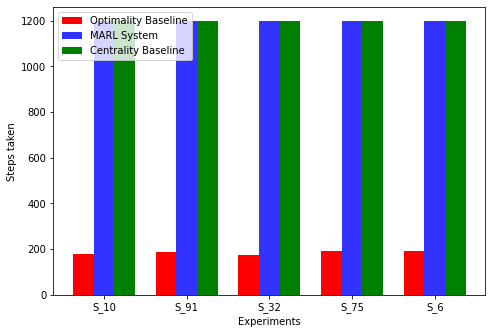

In [11]:
# Plot duration bar graphs from the results
create_chart_bars(experiment_results)

In [12]:
import matplotlib.ticker as mtick


def create_chart_episode_events(results_dict, draw_crashes = False):
    """ Function that plots a graph with either the deliveries of parcels or the crashes of agents
        over the course of an episode, recorded in the :param results_dict:.
        Set the :param draw_crashes: flag for plotting crashes, default are deliveries.
    """
    # TODO Graphen auch abspeichern oder nur hier anzeigen ??
    # TODO - Parcel additions ??
    # TODO - overthink fill with max_value for mean computation 
    
    # Design choices    
    colors = {
        "marl": 'blue',
        "central": 'green',
        "optimal": 'red'
    }
    alpha = 0.6  # Opacity of individual value lines
    alpha_opt = 0.2
    opt_marker_size = 15
    line_width_mean = 5
    line_width_optimal = 2
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    # Retrieve settings values from results dict
    max_steps = results_dict['max_steps']
    max_parcels = results_dict['max_parcels'] 
    max_agents = results_dict['max_agents']
    
    _len = max_agents if draw_crashes else max_parcels
    _len += 1     # start plot at origin

    _key = 'crashed' if draw_crashes else 'delivered'
    
    # Deep copy for further computations
    scenario_results = {k:v for k,v in results_dict.items() if k[0:3] != 'max'}
    
    # for computation of mean
    m_values, c_values, o_values = [], [], []
    Y = [str(i) for i in range(0, _len)]

    # iterate over configs
    for scenario, results in scenario_results.items():

        # Default settings -> MARL run
        color = colors["marl"]
        _type = m_values
        label= "marl_system"

        if scenario[0] == 'C':
            # Baseline run
            color = colors["central"]
            _type = c_values
            label = "centrality_baseline"
            
            # Retrieve and plot optimality baseline
            optimal_time = results['optimal']
            assert optimal_time is not None
            if not draw_crashes: ax.plot(optimal_time, 0, "*", color = colors["optimal"], label="optimality_baseline", markersize=opt_marker_size, alpha= alpha_opt, clip_on=False)   
            o_values.append(optimal_time)
            
        _num_steps = results['step']
        
        X = [0] + list(results[_key].values())
        
                
        X = X + [max_steps]*(_len - len(X))           # Fill X up with max_step values for not delivered parcels / not crashed agents
 
        _type.append(X)  # add X to the respective mean list
        #Y = [str(i) for i in range(0, len(results[_key].values())+1)]
        
        #print("Data: ", results[_key].values())
        #print("new X: ", X)
        #print("new Y: ", Y)
    
        ax.step(X, Y, label=label, where='post', color=color, alpha=alpha)
        
        
        # Attempt to improve the filling mess in the plot...         
        #X = X + [max_steps]*(_len - len(X))           # Fill X up with max_step values for not delivered parcels / not crashed agents
 
        #_type.append(X)  # add X to the respective mean list

        
    # compute mean values
    m_mean = np.mean(np.array(m_values), axis=0)
    c_mean = np.mean(np.array(c_values), axis=0)
    o_mean = np.mean(np.array(o_values), axis=0)

    
    ax.step(m_mean, Y, label="marl_system", where='post', color=colors["marl"], linewidth=line_width_mean)
    ax.step(c_mean, Y, label="centrality_baseline", where='post', color=colors["central"], linewidth=line_width_mean)

    # star for opt:    if not draw_crashes: plt.plot(o_mean, 0, "*", label="optimality_baseline", color="r", markersize=opt_marker_size, clip_on=False)
    # better?: vertical line for opt
    if not draw_crashes: ax.axvline(o_mean, label="optimality_baseline", color=colors["optimal"], linewidth=2, alpha=alpha_opt+0.3)
    
    # y axis as percentage
    max_percent = max_agents if draw_crashes else max_parcels
    xticks = mtick.PercentFormatter(max_percent)
    ax.yaxis.set_major_formatter(xticks)
    
    
    # Lables and Legend
    plt.xlabel("steps")
    ylabel = "% of crashed agents" if draw_crashes else "% of delivered parcels"
    plt.ylabel(ylabel)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    
    # Margins
    plt.ylim(bottom=0)
    plt.xlim()
    plt.margins(x=0, y=0)

    plt.show()
    

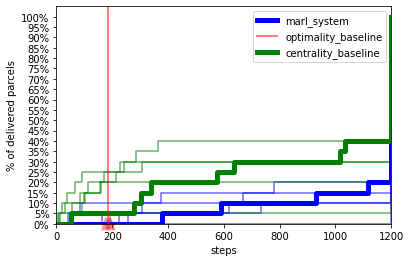

In [13]:
# Plot delivery graphs from the results
create_chart_episode_events(experiment_results, draw_crashes=False)


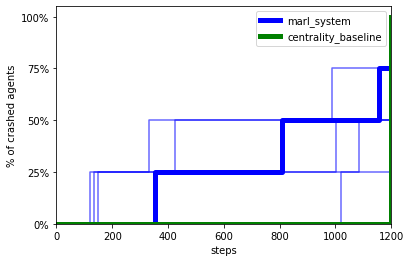

In [15]:
# Plot crash graphs from the results
create_chart_episode_events(experiment_results, draw_crashes=True)

### Manual Actions for debugging

In [ ]:
##################
env_config = {
            'DEBUG_LOGS':False,
            'TOPOLOGY': topology,
            # Simulation config
            'NUMBER_STEPS_PER_EPISODE': 1000,
            #'NUMBER_OF_TIMESTEPS': NUMBER_OF_TIMESTEPS,
            'RANDOM_SEED': None, # 42
            # Map
            'CHARGING_STATION_NODES': [0,1,2,3,4],
            # Entities
            'NUMBER_OF_DRONES': 2,
            'NUMBER_OF_CARS': 2,
            'MAX_BATTERY_POWER': 100,  # TODO split this for drone and car??
            'INIT_NUMBER_OF_PARCELS': 3,
            'MAX_NUMBER_OF_PARCELS': 3,
            'THRESHOLD_ADD_NEW_PARCEL': 0.01,
            # Baseline settings
            'BASELINE_FLAG': False,  # is set True in the test function when needed
            'BASELINE_OPT_CONSTANT': 2.5,
            'BASELINE_TIME_CONSTRAINT': 5,
            # TODO 
            #Rewards
            'REWARDS': {
                'PARCEL_DELIVERED': 200,
                'STEP_PENALTY': -0.1,
            },  
        }
        


env = Map_Environment(env_config)
env.state
#env.ACTION_DROPOFF

In [ ]:
# TODO select actions to give agent 0 reward!!
#print(env.action_space)


actions_1 = {'d_0': 6, 'd_1': 2, 'c_2': 3, 'c_3': 4}
#actions_1 = {'d_0': 0, 'd_1': 0, 'c_2': 5, 'c_3': 5}
actions_2 = {'d_0': 2, 'd_1': 8, 'c_2': 7, 'c_3':0}
actions_3 = {'d_0': 5, 'd_1': 5, 'c_2':2 }

new_obs, rewards, dones, infos = env.step(actions_1)
print(infos)
print(f"New Obs are: {new_obs}")
print(rewards)
print("------------------")
new_obs2, rewards2, dones2, infos2 = env.step(actions_2)
print(f"New Obs are: {new_obs2}")
print(rewards2)
print("------------------")
new_obs3, rewards3, dones3, infos3 = env.step(actions_3)
print(f"New Obs are: {new_obs3}")
print(rewards3)

actions_4 = {'d_0': 0, 'd_1': 0, 'c_2': 1, 'c_3': 0}
actions_5 = {'d_0': 0, 'd_1': 0, 'c_2': 0, 'c_3': 0}
actions_6 = {'d_0': 0, 'd_1': 0, 'c_2': 5, 'c_3': 0}

new_obs, rewards, dones, infos = env.step(actions_4)
print(f"New Obs are: {new_obs}")
print(rewards)
print("------------------")
new_obs2, rewards2, dones2, infos2 = env.step(actions_5)
print(f"New Obs are: {new_obs2}")
print(rewards2)
print("------------------")
new_obs3, rewards3, dones3, infos3 = env.step(actions_6)
print(f"New Obs are: {new_obs3}")
print(rewards3)

print("------------------")
print(dones3)

In [ ]:
# TENSORBOARD
# Load the TensorBoard notebook extension
%load_ext tensorboard
#Start tensorboard below the notebook
#%tensorboard --logdir logs